In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import inv_boxcox
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse,r2_score
import math

from tensorflow import keras

In [2]:
data = pd.read_excel('../data/Processed_data.xlsx')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data = data.drop(data[(data['NOx Mass']<0) | (data['Eng. Speed']<0) | (data['Roll Speed']<0)].index)
data = data.drop(data[(data['CO Mass']==0)].index)
data.isnull().sum(),data.shape

(Test Time         0
 Roll Speed        0
 Eng. Speed        0
 CO Mass           0
 NOx Mass          0
 CO2 Mass          0
 driving cycle     0
 Vehicle           0
 dtype: int64,
 (74176, 8))

In [3]:
data.describe()

,Test Time,Roll Speed,Eng. Speed,CO Mass,NOx Mass,CO2 Mass,Vehicle
count,74176.000000,7.417600e+04,74176.000000,7.417600e+04,7.417600e+04,74176.000000,74176.000000
mean,7108.624590,3.775808e+01,1296.418358,6.747405e-03,4.757227e-03,2.190542,3.434925
std,4088.920177,3.347045e+01,1081.842152,4.681529e-02,9.272865e-03,2.164275,1.709246
min,0.100000,1.881270e-07,0.042635,2.633260e-10,9.261210e-10,0.000649,1.000000
25%,3514.100000,9.896497e+00,730.810000,1.732927e-05,4.306815e-05,0.658664,2.000000
50%,7127.600000,3.126160e+01,1193.330000,5.701690e-05,1.269605e-03,1.374640,4.000000
75%,10737.350000,5.195493e+01,1807.557500,6.606997e-04,5.794280e-03,3.085600,5.000000
max,14018.100000,1.170090e+02,20693.200000,1.464500e+00,1.859920e-01,18.684400,6.000000


In [6]:
data['CO_transformed'] = np.log(data['CO Mass'])
data['NO_transformed'] = np.log(data['NOx Mass'])
data['CO2_transformed'] = np.log(data['CO2 Mass'])

In [7]:
data.describe()

,Test Time,Roll Speed,Eng. Speed,CO Mass,NOx Mass,CO2 Mass,Vehicle,CO_transformed,NO_transformed,CO2_transformed
count,74176.000000,7.417600e+04,74176.000000,7.417600e+04,7.417600e+04,74176.000000,74176.000000,74176.000000,74176.000000,74176.000000
mean,7108.624590,3.775808e+01,1296.418358,6.747405e-03,4.757227e-03,2.190542,3.434925,-9.452813,-7.561234,0.190440
std,4088.920177,3.347045e+01,1081.842152,4.681529e-02,9.272865e-03,2.164275,1.709246,3.195596,2.848061,1.408268
min,0.100000,1.881270e-07,0.042635,2.633260e-10,9.261210e-10,0.000649,1.000000,-22.057628,-20.800016,-7.339814
25%,3514.100000,9.896497e+00,730.810000,1.732927e-05,4.306815e-05,0.658664,2.000000,-10.963113,-10.052727,-0.417541
50%,7127.600000,3.126160e+01,1193.330000,5.701690e-05,1.269605e-03,1.374640,4.000000,-9.772163,-6.669049,0.318192
75%,10737.350000,5.195493e+01,1807.557500,6.606997e-04,5.794280e-03,3.085600,5.000000,-7.322211,-5.150884,1.126746
max,14018.100000,1.170090e+02,20693.200000,1.464500e+00,1.859920e-01,18.684400,6.000000,0.381514,-1.682052,2.927689


In [10]:
xtrain,xtest,ytrain,ytest = train_test_split(data[['Roll Speed','Eng. Speed','driving cycle ','Vehicle']].values,
                                            data[['CO_transformed','NO_transformed','CO2_transformed']].values,shuffle=True,random_state=42,test_size=0.2)
print(f'xtrain shape is {xtrain.shape},xtest shape is {xtest.shape}')
print(f'ytrain shape is {ytrain.shape},ytest shape is {ytest.shape}')                                        

xtrain shape is (59340, 4),xtest shape is (14836, 4)
ytrain shape is (59340, 3),ytest shape is (14836, 3)


In [11]:
xtrain_numeric = xtrain[:,:2]
xtrain_categor = xtrain[:,2:]

xtest_numeric = xtest[:,:2]
xtest_categor = xtest[:,2:]

print(f'xtrain_numeric shape is {xtrain_numeric.shape},xtrain_categor shape is {xtrain_categor.shape}')
print(f'xtest_numeric shape is {xtest_numeric.shape},xtest_categor shape is {xtest_categor.shape}')

xtrain_numeric shape is (59340, 2),xtrain_categor shape is (59340, 2)
xtest_numeric shape is (14836, 2),xtest_categor shape is (14836, 2)


In [12]:
lbl_cycle = LabelEncoder()
lbl_cycle.fit(xtrain_categor[:,0])
drivingCycle_train = lbl_cycle.transform(xtrain_categor[:,0])
drivingCycle_test = lbl_cycle.transform(xtest_categor[:,0])

lbl_vehicle = LabelEncoder()
lbl_vehicle.fit(xtrain_categor[:,1])
vehicle_train = lbl_vehicle.transform(xtrain_categor[:,1])
vehicle_test = lbl_vehicle.transform(xtest_categor[:,1])

In [20]:
scaler_input = MinMaxScaler()
scaler_input.fit(xtrain_numeric)
xtrain_numeric = scaler_input.transform(xtrain_numeric)
xtest_numeric = scaler_input.transform(xtest_numeric)

scaler_output = MinMaxScaler()
scaler_output.fit(ytrain)
ytrain_scaled = scaler_output.transform(ytrain)
ytest_scaled = scaler_output.transform(ytest)

In [14]:
drivingCycle_cats = len(list(np.unique(drivingCycle_train)))
vehicles_cats = len(list(np.unique(xtrain_categor[:,1])))

drivingCycle_embed = int(min(50,drivingCycle_cats+1/2))
vehicles_embed = int(min(50,vehicles_cats+1/2))

print(drivingCycle_cats,vehicles_cats)
print(drivingCycle_embed,vehicles_embed)

9 6
9 6


In [21]:
# categorical variable 
drivingCycle_catinput = keras.layers.Input(shape=(1,),name='Driving Cycle input')
drivingCycle_embedinput = keras.layers.Embedding(drivingCycle_cats,drivingCycle_embed)(drivingCycle_catinput)
drivingCycle_flatten = keras.layers.Flatten()(drivingCycle_embedinput)

vehicles_catinput = keras.layers.Input(shape=(1,),name='Vehicle Input')
vehicles_embedinput = keras.layers.Embedding(vehicles_cats,vehicles_embed)(vehicles_catinput)
vehicle_flatten = keras.layers.Flatten()(vehicles_embedinput)

# numerical variable
numerical_input = keras.layers.Input(shape=(2,), name='numeric_input')

# merged
merged = keras.layers.concatenate([numerical_input, drivingCycle_flatten,vehicle_flatten])
# lstm_out0 = keras.layers.LSTM(32,return_sequences=True,activation='relu')(merged)
# lstm_out1 = keras.layers.LSTM(16,return_sequences=True,activation='relu')(merged)
# lstm_out2 = keras.layers.LSTM(8,return_sequences=True,activation='relu')(lstm_out1)
# lstm_out3 = keras.layers.LSTM(4,return_sequences=True,activation='relu')(lstm_out2)
flattened = keras.layers.Flatten()(merged)
# dense_out0 = keras.layers.Dense(32,activation='relu')(flattened)
dense_out1 = keras.layers.Dense(16)(flattened)
dense_out2 = keras.layers.Dense(8)(dense_out1)
dense_out3 = keras.layers.Dense(3)(dense_out2)

model = keras.Model([numerical_input, drivingCycle_catinput,vehicles_catinput], dense_out3)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Driving Cycle input (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
Vehicle Input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 9)         81          Driving Cycle input[0][0]        
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 6)         36          Vehicle Input[0][0]              
____________________________________________________________________________________________

In [22]:
adam = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='mse',metrics=['mae'],optimizer=adam)

In [23]:
history = model.fit(x=[xtrain_numeric,drivingCycle_train,vehicle_train],y=ytrain_scaled,batch_size=32,validation_split=0.1,epochs=200)

: 0.0090 - val_mae: 0.0643
Epoch 57/200
1669/1669 [==============================] - 1s 779us/step - loss: 0.0090 - mae: 0.0646 - val_loss: 0.0090 - val_mae: 0.0642
Epoch 58/200
1669/1669 [==============================] - 1s 761us/step - loss: 0.0091 - mae: 0.0648 - val_loss: 0.0090 - val_mae: 0.0644
Epoch 59/200
1669/1669 [==============================] - 1s 805us/step - loss: 0.0089 - mae: 0.0644 - val_loss: 0.0090 - val_mae: 0.0646
Epoch 60/200
1669/1669 [==============================] - 1s 807us/step - loss: 0.0089 - mae: 0.0645 - val_loss: 0.0090 - val_mae: 0.0643
Epoch 61/200
1669/1669 [==============================] - 1s 755us/step - loss: 0.0090 - mae: 0.0646 - val_loss: 0.0090 - val_mae: 0.0643
Epoch 62/200
1669/1669 [==============================] - 1s 754us/step - loss: 0.0089 - mae: 0.0644 - val_loss: 0.0090 - val_mae: 0.0642
Epoch 63/200
1669/1669 [==============================] - 1s 793us/step - loss: 0.0089 - mae: 0.0643 - val_loss: 0.0090 - val_mae: 0.0641
Epoch 6

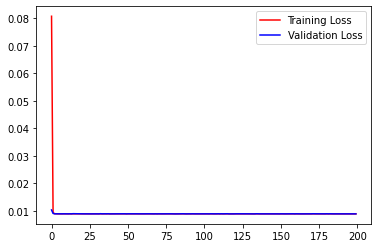

In [24]:
plt.plot(history.history['loss'],color='r',label='Training Loss')
plt.plot(history.history['val_loss'],color='b',label='Validation Loss')
plt.legend()
plt.show()

In [25]:
pred = model.predict([xtest_numeric,drivingCycle_test,vehicle_test])
print(pred.shape)

(14836, 3)


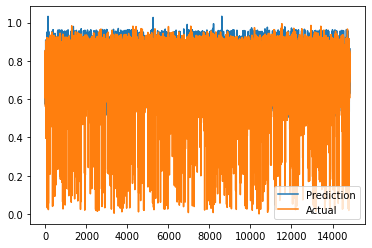

In [29]:
p=2
plt.plot(pred[:,p],label='Prediction')
plt.plot(ytest_scaled[:,p],label='Actual')
plt.legend()
plt.show()

In [30]:
pred = scaler_output.inverse_transform(pred)
pred = 10 ** pred

ytest = 10**ytest

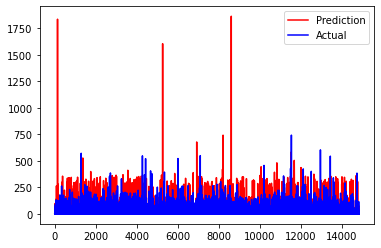

In [38]:
p=2
plt.plot(pred[:,p],color='r',label='Prediction')
plt.plot(ytest[:,p],color='b',label='Actual')
plt.legend()
plt.show()

In [37]:
for i in range(0,3):
    print(f'for {i} RMSE is {math.sqrt(mse(ytest[:,i],pred[:,i]))*1000} and R2 is {r2_score(ytest[:,i],pred[:,i])*100}')

for 0 RMSE is 39.482414043454696 and R2 is -0.31430950584367956
for 1 RMSE is 0.29284349323632003 and R2 is 0.8852143315341454
for 2 RMSE is 44141.84011972922 and R2 is -42.53260934331309
